In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
import random

In [2]:
#Read data

chrs=["NW_022145594.1","NW_022145594.1","NW_022145597.1","NW_022145600.1","NW_022145601.1","NW_022145603.1","NW_022145606.1","NW_022145609.1","NW_022145610.1"]
starts = [12702886,39429440,14219351,33842803,28950395,8291260,16610900, 29427741,30779143]
ends = [13424367,42445994,14298524,34582517,29566247,9094120,16737625, 29776196,31460853] 
inv_counter=0
invsy = []
backsy = []
xs=[]
ps = []
ave1s = []
ave2s = []
for mychr in chrs:
    df=pd.read_csv(f"tmrca_results/{mychr}.TMRCA.txt", sep=" ", names=["ID", "pos", "numindata", "clock", "filer", "Cpairs", "Dpairs", "ave", "median", "mode", "label"])
    df["pos"] = df.pos.astype('int')
    df=df.sort_values(by="pos")
    df[["chrom","ch_end", "num1", "num2"]]=df.ID.str.split('.', expand=True)
    df["corr_chrom"] = df["chrom"] + "." + df["ch_end"]

    start1=starts[inv_counter]
    end1=ends[inv_counter]

    if inv_counter == 0:
        bp1=df[(df["pos"]>=start1) & (df["pos"]<=end1)]
        bp2=df[(df["pos"]>=15422748) & (df["pos"]<=16793794)]
        bps=pd.concat([bp1, bp2], ignore_index=True)
    else:
        bps=df[(df["pos"]>=start1) & (df["pos"]<=end1)]
    
    rest=df.merge(bps, on=list(df.columns), how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

    list1=bps.ave.to_list()
    list2=rest.ave.to_list()

    resdf = pd.DataFrame({'Values': list1 + list2, 
                    'Group': ['Breakpoints'] * len(list1) + ['Rest'] * len(list2)})

    #stats
    stat, p_value = stats.mannwhitneyu(list1, list2, alternative='two-sided')
    #print("p_val:", p_value)
    ave1=sum(list1)/len(list1)
    ave2=sum(list2)/len(list2)
    #print(ave1,ave2)

    values_bp = np.array(list1)
    values_rest = np.array(list2)
    kde_bp = gaussian_kde(values_bp)
    kde_rest = gaussian_kde(values_rest)

    x_vals = np.linspace(min(resdf['Values']), max(resdf['Values']), 100)

    invsy.append(list1)
    backsy.append(list2)
    ps.append(p_value)
    ave1s.append(ave1)
    ave2s.append(ave2)

    inv_counter+=1

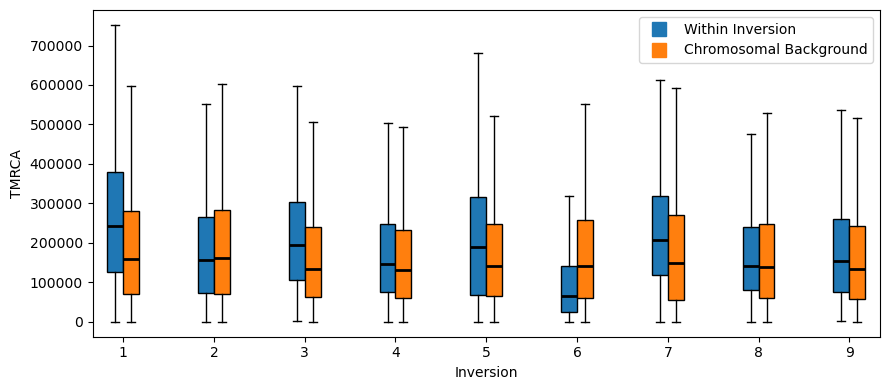

In [3]:
#Plotting

colors = ['C0', 'C1']
box_width = 0.35
n = len(invsy)

positions = []
for i in range(n):
    positions.append(i * 2 + 1)    
    positions.append(i * 2 + 1 + box_width)  

# Flatten the data and assign positions and colors
data = []
plot_positions = []
plot_colors = []
for i in range(n):
    data.append(invsy[i])
    plot_positions.append(positions[i*2])
    plot_colors.append(colors[0])
    
    data.append(backsy[i])
    plot_positions.append(positions[i*2 + 1])
    plot_colors.append(colors[1])


fig, ax = plt.subplots(figsize=(9,4))
bp = ax.boxplot(data, positions=plot_positions, widths=box_width, patch_artist=True,showfliers=False)

for patch, color in zip(bp['boxes'], plot_colors):
    patch.set_facecolor(color)

for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

# x-axis labels centered between pairs
mid_positions = [(positions[i*2] + positions[i*2 + 1]) / 2 for i in range(n)]
ax.set_xticks(mid_positions)
ax.set_xticklabels([f'{i+1}' for i in range(n)])

ax.legend(handles=[
    plt.Line2D([], [], color='C0', marker='s', linestyle='None', markersize=10, label='Within Inversion'),
    plt.Line2D([], [], color='C1', marker='s', linestyle='None', markersize=10, label='Chromosomal Background')
], loc='upper right')

ax.set_xlabel('Inversion')
ax.set_ylabel('TMRCA')

plt.tight_layout()
plt.savefig(f'figs/tmrca_all_invs.pdf', format='pdf', bbox_inches='tight')
